In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure, color, io
from skimage.segmentation import clear_border

#this function is used to import images in openCV format
def import_image(image_directory, colored = 0):
    return cv2.imread(image_directory, colored)


#this function can be used to easily display open cv images using matplotlib without writing alot of code 
def display_image(*images, titles=None):
    n_images = len(images)
    if titles is None:
        titles = [f"Image {i+1}" for i in range(n_images)]

    #create a subplot for multiple images
    plt.figure(figsize=(15, 5))

    for i, img in enumerate(images):
        plt.subplot(1, n_images, i + 1)
        plt.title(titles[i])
        plt.axis('off')  # Hide axes

        #handle grayscale vs RGB
        if len(img.shape) == 2:  #Grayscale
            plt.imshow(img, cmap='gray')
        elif len(img.shape) == 3 and img.shape[2] == 3:  #RGB
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            raise ValueError("Unsupported image format")

    plt.show()

#This function is used to conveniently plot the histogram of an image or multiple images
def print_histogram(*images, titles=None):
    n_images = len(images)

    #if no titles are provided, generate default titles
    if titles is None:
        titles = [f"Histogram {i+1}" for i in range(n_images)]
    #ensure the number of titles matches the number of images
    if len(titles) != n_images:
        raise ValueError("Number of titles must match number of images.")
    #create a figure with subplots for multiple histograms
    plt.figure(figsize=(12, 6))
    
    for i, image in enumerate(images):
        #convert to grayscale if the image is not already
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        #calculate histogram
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])


        #plot the histogram
        plt.subplot(1, n_images, i + 1)
        plt.plot(hist)
        plt.title(titles[i])
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.grid(True)

    plt.tight_layout()  #adjust the layout for better spacing between subplots
    plt.show()


In [2]:
#image enhancement techniques
import numpy as np

#power rule transformation is responsible of changing the image contrast using a certain value 'gamma'
#if the value is between 0 and 1, then the image will become less contrasty
#if the value is higher than 1, then there will be more contrast
def power_law_transform(image, gamma):
    #first we normalize the image to a value between 0 and 1
    normalized_img = image / 255.0
    #then we use numpy to apply the power values to each value in the matrix
    transformed_img = np.power(normalized_img, gamma)
    #we finally scale values back to this range between 0 and 255 as integers
    transformed_img = np.uint8(transformed_img * 255)
    return transformed_img

#histogram equaliztion is a method that aims to improve image contrast and visibility by making the gray level distribution more uniform
def histogram_eqaulize(image):
    return cv2.equalizeHist(image)

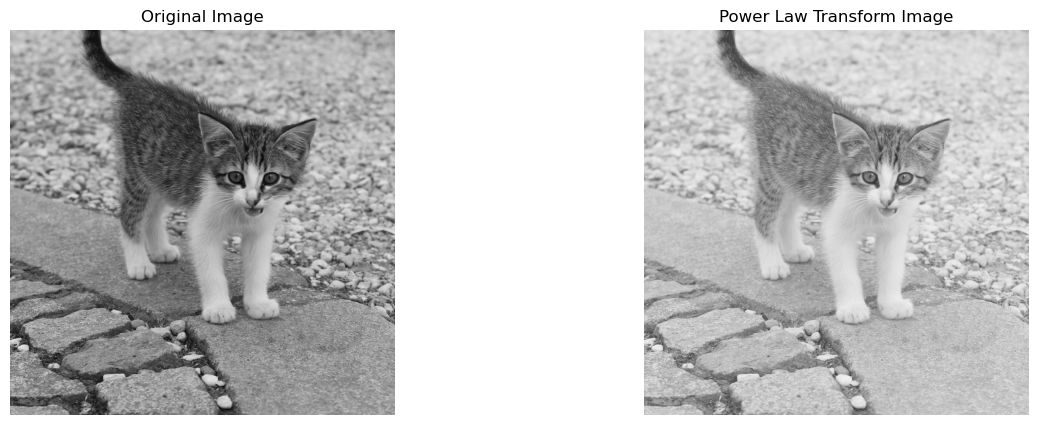

In [3]:
image = import_image("kitten.jpg")

plt_image = power_law_transform(image, 0.5)
display_image(image, plt_image, titles = ["Original Image","Power Law Transform Image"])

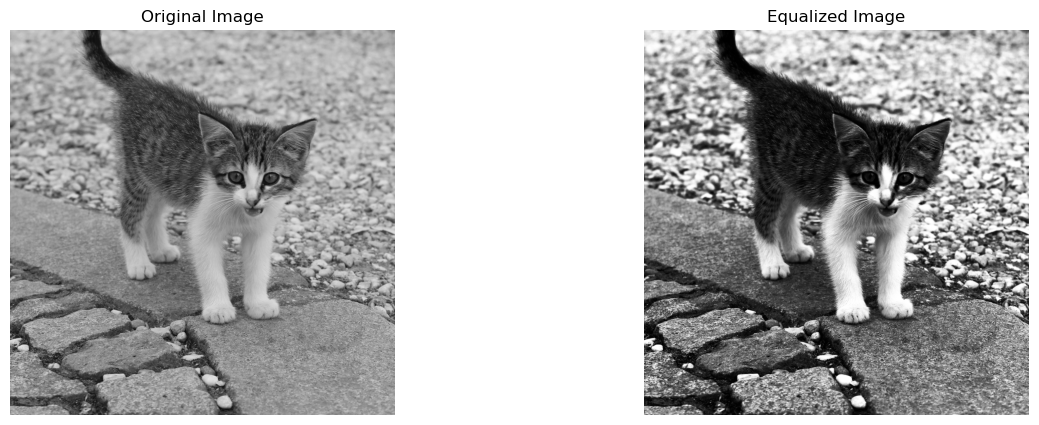

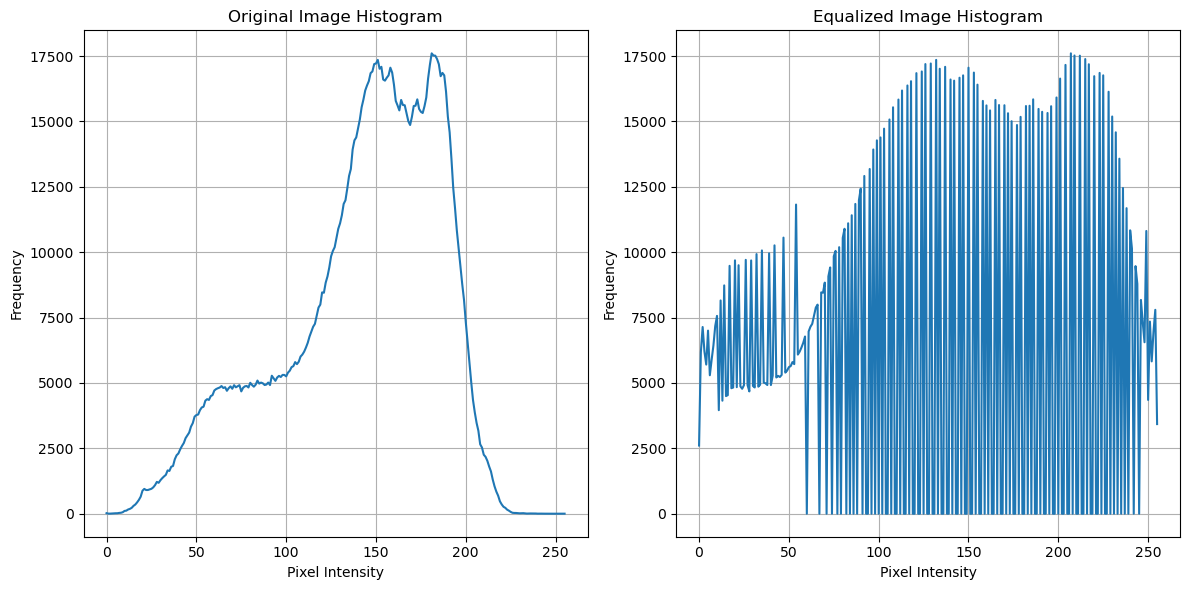

In [4]:
equalized_image = histogram_eqaulize(image)
display_image(image, equalized_image, titles = ["Original Image","Equalized Image"])

print_histogram(image, equalized_image, titles = ["Original Image Histogram","Equalized Image Histogram"])

In [5]:
#image compression techniques

#this compression technique aims to discrete fourier transform an image to the frequency domain and cuts the higher frequencies of the image
#before trnasforming it back to its original matrix form, the result will end up being a smaller image size with few loss and artifacts
#the larger the cutoff radius value, the more we retain high
def dft_high_frequency_cut(image, cutoff_radius):

    original_shape = image.shape
    #square resize the image to square format first, because dft masking only works with square images. If the image is narrow or wide it will not be visible.
    image = cv2.resize(image, (np.max(original_shape), np.max(original_shape)), interpolation = cv2.INTER_LANCZOS4)
    #The cut off radius represents a percentage from 0 to 100 to the radius of the entire image
    cutoff_radius = int(np.max(original_shape) * (cutoff_radius/100))
    #perform DFT using NumPy
    dft = np.fft.fft2(image)
    #shift the high frequency component to the center
    dft_shift = np.fft.fftshift(dft)
    #we then create a mask to filter high frequencies
    rows, cols = image.shape
    #calculte the center of the image
    crow, ccol = rows // 2, cols // 2

    #create a circular mask with low frequencies, cutoff_radius defines the size of the mask
    #the mask should have the same shape as the DFT (rows, cols)
    mask = np.zeros((rows, cols), np.uint8)
    center = (crow, ccol)
    #keep lower frequencies
    cv2.circle(mask, center, cutoff_radius, (1), thickness=-1)

    #apply the mask to the shifted DFT
    fshift = dft_shift * mask

    #Final step is to inverse DFT to get the compressed image back
    #we invert the shifting that has been done using this numpy function
    f_ishift = np.fft.ifftshift(fshift)
    #perform inverse DFT
    img_back = np.fft.ifft2(f_ishift)  # Use ifft2 for inverse DFT
    #then get the magnitude
    img_back = np.abs(img_back) # Get the absolute value for the magnitude

    #normalize the image to the 0-255 range and return the result
    img_back = np.uint8(np.clip(img_back, 0, 255))

    #resize the image back to its original dimensions
    img_back = cv2.resize(img_back, (original_shape[1], original_shape[0]), interpolation = cv2.INTER_LANCZOS4)
    return img_back

#this function aims to compress an image by reducing the number of gray levels
#it takes the image, the number of gray levels k, and the maximum number of iterations
def kmeans_quantization(image, k, max_iterations):
    #check if image is grayscale
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #reshape image to 1D array for processing
    rows, cols = image.shape
    pixels = image.reshape(-1)
    
    #initialize centroids randomly between 0-255
    centroids = np.random.randint(0, 256, k, dtype=np.uint8)
    
    for iteration in range(max_iterations):
        #store old centroids to check for convergence
        old_centroids = centroids.copy()
        
        #step 1, assign each pixel to nearest centroid
        #initialize array to store cluster assignments
        labels = np.zeros(len(pixels), dtype=np.uint8)
        
        #for each pixel, find closest centroid
        for i in range(len(pixels)):
            distances = np.abs(pixels[i] - centroids)
            closest_centroid = np.argmin(distances)
            labels[i] = closest_centroid
            
        #step 2, Update centroids based on mean of assigned pixels
        for i in range(k):
            #get all pixels assigned to this cluster
            cluster_pixels = pixels[labels == i]
            if len(cluster_pixels) > 0:
                #update centroid to mean of cluster
                centroids[i] = np.mean(cluster_pixels).astype(np.uint8)
            else:
                #if cluster is empty, assign random value
                centroids[i] = np.random.randint(0, 256, dtype=np.uint8)
        
        #check for convergence
        if np.array_equal(old_centroids, centroids):
            break
    
    #create output image by mapping each pixel to its centroid
    quantized = np.zeros_like(pixels)
    for i in range(len(pixels)):
        quantized[i] = centroids[labels[i]]
    
    #reshape back to original image dimensions
    quantized = quantized.reshape(rows, cols)
    
    return quantized

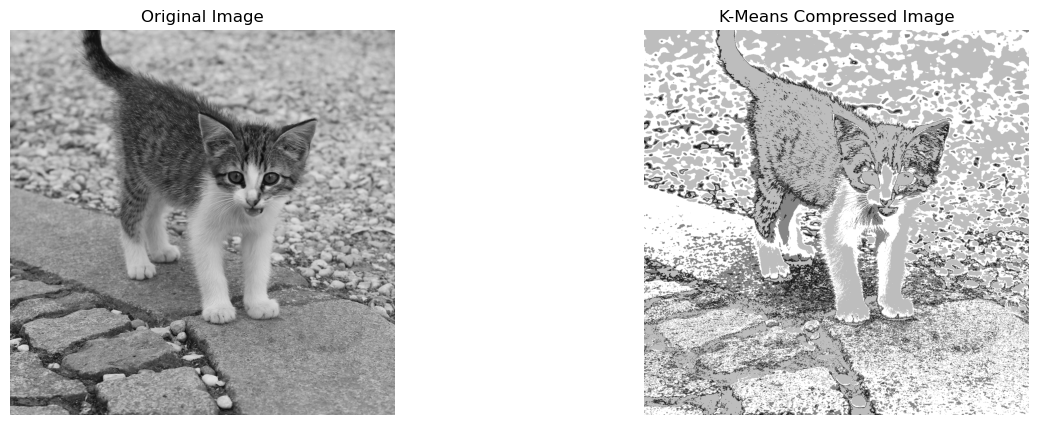

In [7]:
kmeans_image = kmeans_quantization(image, 5, 3)
display_image(image, kmeans_image, titles = ["Original Image","K-Means Compressed Image"])

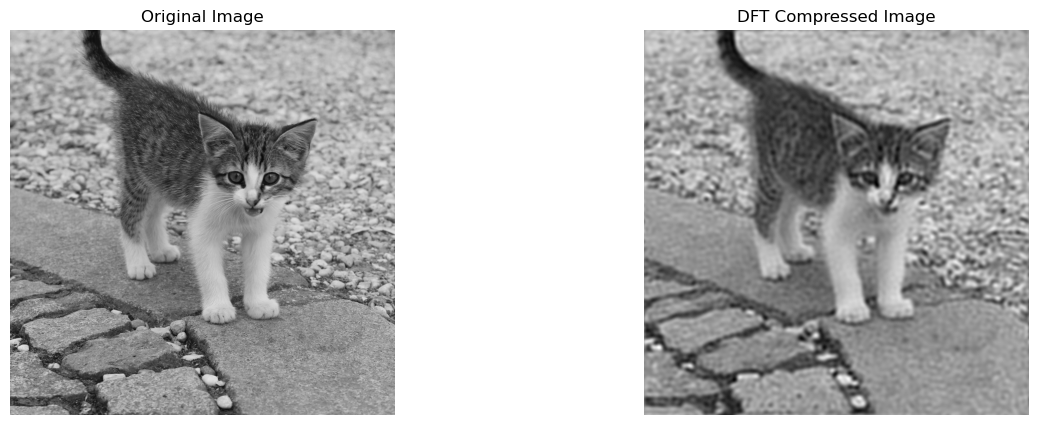

In [9]:
dft_compressed_image = dft_high_frequency_cut(image, 5)
display_image(image, dft_compressed_image, titles = ["Original Image","DFT Compressed Image"])

In [10]:
#image segmentation techniques

#thresholding technique basically creates a binary image mask given a threshold cut value
#anything lower this value will be dimmed completely while anything higher than it will be set to 255
def threshold_segment(image, threshold_val, invert_mask=False):
    
    #create a zeros matrix using the same shape of the image
    thresh_mask = np.zeros(image.shape, dtype=np.uint8)

    #pixels within the specified range are emphasized and kept, others are disregarded
    thresh_mask[(image >= threshold_val) & (image <= 255)] = 255

    #if we want to segment the darker areas and disregard the brighter ones instead 
    if invert_mask:
        thresh_mask = cv2.bitwise_not(thresh_mask)
    
    #apply the mask to the image using btwise anding
    thresh_image = cv2.bitwise_and(image, image, mask=thresh_mask)
    
    return thresh_image

#The watershed segmentation function
def watershed_segment(image):
    # Ensure the image is a 3-channel image
    if len(image.shape) == 2 or image.shape[2] == 1:  # Convert grayscale to BGR
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
    #We need to use thresholding to seperate the background from the foreground objects
    #Otsu's method is an automatic technique that thresholds an image automatically using histogram analysis
    #wich mean that we don't have to define the thresholding point ourselves
    _, thresh = cv2.threshold(image[:, :, 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #remove noise using morphological transformation, it removes the small white spots from the background
    #we achieve this by using a 3x3 kernel or filter that convolutionally traverses all the pixels to apply the effect
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

    #we then remove the white elements that touch the borders of the image
    opening = clear_border(opening)
    
    #We then use dialaitng which help ensure that the foreground objects are properly separated
    sure_bg = cv2.dilate(opening,kernel,iterations=1)

    #This function calculates the eucledian distance transformation. 
    #It is used to calculate each pixel from the nearest zero background pixel.
    #sqrt((x1-x2)^2 + (y1+y2)^2)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    
    #we then set a thresholding value to 20% mx dynamically
    #pixels with values above this threshold are considered part of the "sure foreground"
    #while others are considered part of the uncertain region
    _, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    
    #we then subtract both the background and foreground masks to determine the region of uncertainty
    #in this are we are not sure wether those pixels belong to the background or the foreground
    unknown = cv2.subtract(sure_bg,sure_fg)

    #this function labels connected components in the image for the watershed algorithm.
    _, markers = cv2.connectedComponents(sure_fg)

    markers = markers+10

    #mark unknown regions with 0
    markers[unknown==255] = 0

    #we finally apply the watershed and mark the boundaries
    markers = cv2.watershed(image, markers)

    watershed_result = image.copy()
    
    #objects’ boundaries are marked 
    watershed_result[markers == -1] = [0, 0, 255]

    return cv2.cvtColor(watershed_result, cv2.COLOR_BGR2RGB)

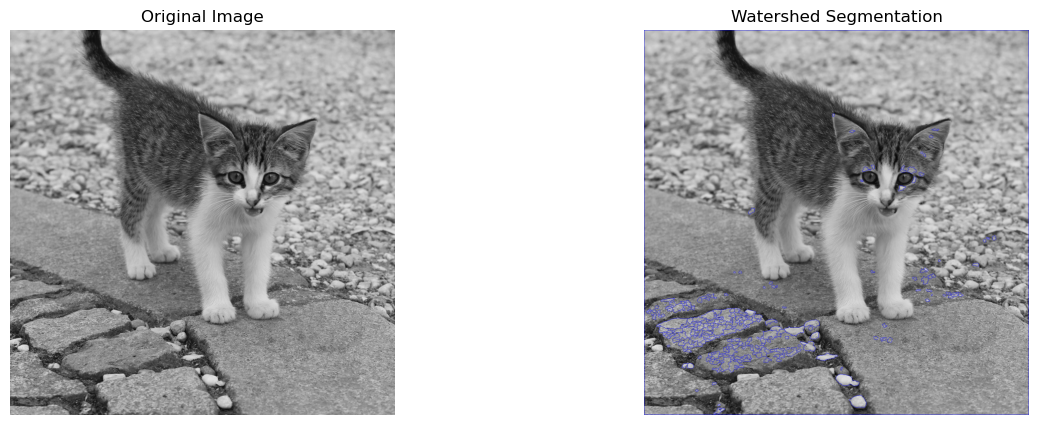

In [11]:
watersheded_image = watershed_segment(image)
display_image(image, watersheded_image, titles = ["Original Image","Watershed Segmentation"])

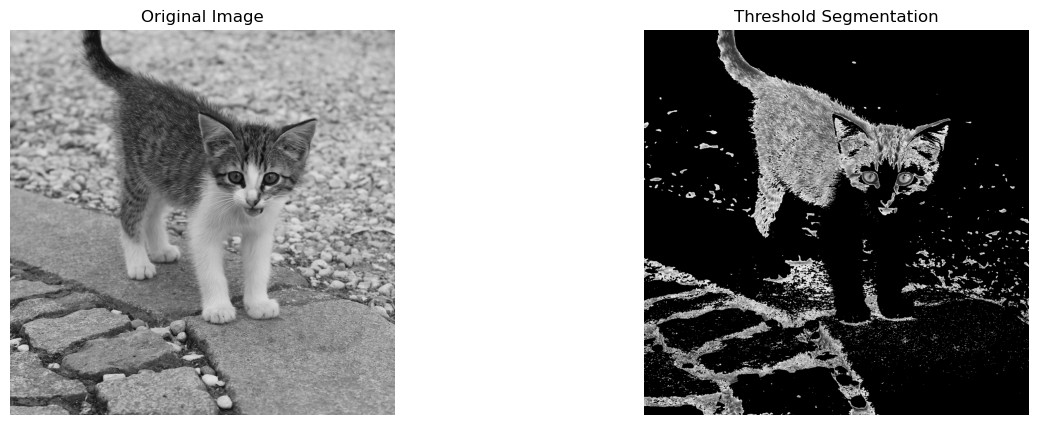

In [12]:
thresh_image = threshold_segment(image, 100, True)
display_image(image, thresh_image, titles = ["Original Image","Threshold Segmentation"])

In [15]:
import gradio as gr

interface = None

#function to plot equalization comparison histogram 
def plot_histograms(original_image, equalized_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].hist(original_image.ravel(), 256, [0, 256])
    axes[0].set_title("Original Histogram")
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(equalized_image.ravel(), 256, [0, 256])
    axes[1].set_title("Equalized Histogram")
    axes[1].set_xlabel("Pixel Intensity")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    return fig

#processing function
def process_image(image, gamma, cutoff_radius, threshold_val, invert_mask, k, max_iterations):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #apply Power Law Transformation
    power_law_img = power_law_transform(gray_image, gamma)
    
    #apply Histogram Equalization
    hist_eq_img = histogram_eqaulize(gray_image)

    #apply DFT High Frequency Cut
    dft_img = dft_high_frequency_cut(gray_image, cutoff_radius)

    #apply threshold segmentation
    threshold_img = threshold_segment(gray_image, threshold_val, invert_mask)
    
    #apply watershed segmentation to highlight region of interest
    watershed_img = watershed_segment(gray_image)

    #apply k-means quantization
    kmeans_img = kmeans_quantization(gray_image, k, max_iterations)
    
    #Plot histograms
    hist_fig = plot_histograms(gray_image, hist_eq_img)

    return power_law_img, hist_eq_img, dft_img, threshold_img, watershed_img, kmeans_img, hist_fig

#Gradio Interface
inputs = [
    gr.Image(type="numpy", label="Upload Image"),
    gr.Slider(0.1, 3.0, value=1.0, label="Gamma Value"),
    gr.Slider(10, 100, value=30, label="Cutoff Radius for DFT"),
    gr.Slider(0, 255, value=127, label="Threshold point for segmentation"),
    gr.Checkbox(label="Invert Mask", value=False),  #checkbox for mask inversion
    gr.Slider(2, 20, value=5, step=1, label="K (Number of Clusters for K-Means)"),
    gr.Slider(1, 50, value=10, step=1, label="Max Iterations for K-Means")
]

outputs = [
    gr.Image(label="Power Law Transformation", format="webp"),
    gr.Image(label="Histogram Equalization", format="webp"),
    gr.Image(label="DFT High Frequency Cut", format="webp"),
    gr.Image(label="Threshold Segmented Image", format="webp"),
    gr.Image(label="Watershed Segmented Image", format="webp"),
    gr.Image(label="K-Means Quantized Image", format="webp"),
    gr.Plot(label="Histograms: Original vs Equalized"),
]

#close gradio interface if it's already open
if interface != None:
    try:
        interface.close()
    except NameError:
        pass

#add image processing function, input sliders and labels to Gradio interface, launch web interface through a single line
interface = gr.Interface(fn=process_image, inputs=inputs, outputs=outputs, title="Image Processing Techniques")
interface.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
